#### **<h3 style="text-align:center;">1. Data Extraction and Preparation</h3>**

##### 1.1. Connect to SQLite.
##### 1.2. Inspect the tables.
##### 1.3. Convert `Period` to a proper Date/Time

In [14]:
import sqlite3
import pandas as pd

# Paths to files
db_path = "C:/Users/user/OneDrive/Documentos/FAU_Medical_Engineering/Subjects/SEMESTER_4/Methods_Advanced_Data_Engineering/Projects/Project_7_Final_Report/data/Housing_Tourism_Data.sqlite"
output_dir = "C:/Users/user/OneDrive/Documentos/FAU_Medical_Engineering/Subjects/SEMESTER_4/Methods_Advanced_Data_Engineering/Projects/Project_7_Final_Report/Figures"

# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Fetch table names to confirm structure
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(table_query, conn)

# Load the three tables into pandas DataFrames
tables_data = {table: pd.read_sql_query(f"SELECT * FROM {table}", conn) for table in tables['name']}

# Close connection
conn.close()

# Display table names and first few rows of each table to inspect the data
tables_data_display = {name: df.head() for name, df in tables_data.items()}
tables_data_display

####################################################################################################################

# Function to convert Period column to datetime (for further processing)
def convert_period_to_date(df, period_col):
    df[period_col] = pd.to_datetime(df[period_col] + ".01", format="%Y.%m.%d")
    return df

# Convert Period column in each table to datetime format
tables_data['sales_rents_2011_2021'] = convert_period_to_date(tables_data['sales_rents_2011_2021'], 'Period')
tables_data['monthly_entry_colombians_foreigners'] = convert_period_to_date(tables_data['monthly_entry_colombians_foreigners'], 'Period')
tables_data['monthly_passengers_origin'] = convert_period_to_date(tables_data['monthly_passengers_origin'], 'Period')

# Display updated Period columns to verify the conversion
updated_period_display = {name: df[['Period']].head() for name, df in tables_data.items()}
updated_period_display


{'sales_rents_2011_2021':       Period
 0 2011-01-01
 1 2011-01-01
 2 2011-01-01
 3 2011-01-01
 4 2011-01-01,
 'monthly_entry_colombians_foreigners':       Period
 0 2022-09-01
 1 2022-09-01
 2 2021-09-01
 3 2021-09-01
 4 2020-09-01,
 'monthly_passengers_origin':       Period
 0 2022-09-01
 1 2022-09-01
 2 2022-09-01
 3 2022-09-01
 4 2022-09-01}

#### **<h3 style="text-align:center;">2. Create Aggregated Time Series</h3>**

##### 2.1. Tourism Aggregation:
- Domestic: From `montly_entry_colombians_foreigners`, filter by `Nationality` = `Colombiano` and sum `Number` by `Period`.
- From the same table, filter by `Nationality` = `Extranjero` and sum `Number` by `Period`.
##### 2.2. Housing Aggregation:
- Sales: `Research = 'VENTA'`
- Rentals: `Research = 'ARRENDAMIENTO'`
##### 2.3. Combine into Single Dataframe: After each dataset is aggregated by month, we can merge them (join on the `Period` column).

In [15]:
# Aggregating Tourism Data

# Domestic travelers
domestic_tourism = (
    tables_data['monthly_entry_colombians_foreigners']
    .loc[tables_data['monthly_entry_colombians_foreigners']['Nationality'] == 'Colombiano']
    .groupby('Period')['Number']
    .sum()
    .reset_index()
    .rename(columns={'Number': 'Total_Colombian_Travelers'})
)

# Inbound (foreign) travelers
foreign_tourism = (
    tables_data['monthly_entry_colombians_foreigners']
    .loc[tables_data['monthly_entry_colombians_foreigners']['Nationality'] == 'Extranjero']
    .groupby('Period')['Number']
    .sum()
    .reset_index()
    .rename(columns={'Number': 'Total_Foreign_Travelers'})
)

# Aggregating Housing Data

# Function for housing aggregation
def aggregate_housing(df, research_type):
    filtered = df.loc[df['Research'] == research_type]
    grouped = (
        filtered.groupby('Period')
        .agg(
            Average_Price_per_m2=('Price_per_m2_COP', 'mean'),
            Median_Price_per_m2=('Price_per_m2_COP', 'median'),
            Total_Units=('Price_per_m2_COP', 'count'),
            Total_Private_Area=('Private_Area_m2', 'sum'),
            Average_Lot_Area=('Lot_Area_m2', 'mean')
        )
        .reset_index()
    )
    return grouped

# Aggregating for sales and rentals
sales_aggregation = aggregate_housing(tables_data['sales_rents_2011_2021'], 'VENTA').rename(columns={
    'Average_Price_per_m2': 'Sales_Avg_Price_per_m2',
    'Median_Price_per_m2': 'Sales_Median_Price_per_m2',
    'Total_Units': 'Sales_Total_Units',
    'Total_Private_Area': 'Sales_Total_Private_Area',
    'Average_Lot_Area': 'Sales_Avg_Lot_Area'
})

rentals_aggregation = aggregate_housing(tables_data['sales_rents_2011_2021'], 'ARRENDAMIENTO').rename(columns={
    'Average_Price_per_m2': 'Rentals_Avg_Price_per_m2',
    'Median_Price_per_m2': 'Rentals_Median_Price_per_m2',
    'Total_Units': 'Rentals_Total_Units',
    'Total_Private_Area': 'Rentals_Total_Private_Area',
    'Average_Lot_Area': 'Rentals_Avg_Lot_Area'
})

# Combining Aggregated Data

# Merge tourism data
tourism_data = pd.merge(domestic_tourism, foreign_tourism, on='Period', how='outer')

# Merge with housing data
aggregated_data = tourism_data.copy()
for housing_data in [sales_aggregation, rentals_aggregation]:
    aggregated_data = pd.merge(aggregated_data, housing_data, on='Period', how='outer')

# Display the combined aggregated dataframe
# import ace_tools as tools

# tools.display_dataframe_to_user(name="Aggregated Tourism and Housing Data", dataframe=aggregated_data)
from IPython.display import display, HTML

# Display the DataFrame with a custom title
def display_dataframe_to_user(name, dataframe):
    print(f"Displaying: {name}")
    display(HTML(f"<h3>{name}</h3>"))
    display(dataframe)

# Use the function
display_dataframe_to_user(name="Aggregated Tourism and Housing Data", dataframe=aggregated_data)

Displaying: Aggregated Tourism and Housing Data


,Period,Total_Colombian_Travelers,Total_Foreign_Travelers,Sales_Avg_Price_per_m2,Sales_Median_Price_per_m2,Sales_Total_Units,Sales_Total_Private_Area,Sales_Avg_Lot_Area,Rentals_Avg_Price_per_m2,Rentals_Median_Price_per_m2,Rentals_Total_Units,Rentals_Total_Private_Area,Rentals_Avg_Lot_Area
0,2011-01-01,16505,9763,1.214384e+06,1049682.5,132.0,18198.0,101.393939,12007.257642,10714.0,229.0,21234.0,49.161572
1,2011-02-01,27608,8393,1.510957e+06,1363636.0,127.0,13925.0,73.165354,9401.536496,9167.0,548.0,48282.0,56.585766
2,2011-03-01,14298,9283,1.395383e+06,1262255.0,190.0,20847.0,77.284211,10723.046512,10185.0,258.0,19971.0,41.693798
3,2011-04-01,20897,10541,1.247028e+06,1127011.5,110.0,12573.0,87.718182,7629.701613,7000.0,124.0,8987.0,40.403226
4,2011-05-01,19120,10230,9.545158e+05,682731.0,603.0,64570.0,74.751244,9920.415190,9474.0,395.0,31746.0,48.972152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2022-10-01,70900,51679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,2022-11-01,67739,60316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,2022-12-01,84891,70520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2023-01-01,74677,62945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **<h3 style="text-align:center;">3. Exploratory Data Analysis (EDA) & Visualization</h3>**

##### 3.1. Check Trends over Time
##### 3.2. Correlation Analysis: Compute simple correlation coefficients (e.g., Pearson’s r or Spearman’s ρ) between the aggregated tourism series and the aggregated housing metrics (e.g. average sale price, average rent price).
##### 3.3. Lagged Correlations

In [16]:
# import packages

import matplotlib.pyplot as plt 
import seaborn as sns
import os

In [17]:
# Filter the data for the time period 2011 to 2021
filtered_data = aggregated_data[
    (aggregated_data['Period'] >= "2011-01-01") & (aggregated_data['Period'] <= "2021-12-31")
]

# Identify top 5-10 highest values for the orange and green lines
sales_outliers = filtered_data[['Period', 'Sales_Avg_Price_per_m2']].nlargest(10, 'Sales_Avg_Price_per_m2')
rentals_outliers = filtered_data[['Period', 'Rentals_Avg_Price_per_m2']].nlargest(10, 'Rentals_Avg_Price_per_m2')

# Replace outliers with interpolated values
filtered_data.loc[filtered_data['Sales_Avg_Price_per_m2'].isin(sales_outliers['Sales_Avg_Price_per_m2']), 'Sales_Avg_Price_per_m2'] = None
filtered_data.loc[filtered_data['Rentals_Avg_Price_per_m2'].isin(rentals_outliers['Rentals_Avg_Price_per_m2']), 'Rentals_Avg_Price_per_m2'] = None

# Interpolate missing values after removing outliers
numeric_columns = ['Sales_Avg_Price_per_m2', 'Rentals_Avg_Price_per_m2']
filtered_data[numeric_columns] = filtered_data[numeric_columns].interpolate(method='linear')


C:\Users\user\AppData\Local\Temp\ipykernel_15320\1977591582.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[numeric_columns] = filtered_data[numeric_columns].interpolate(method='linear')


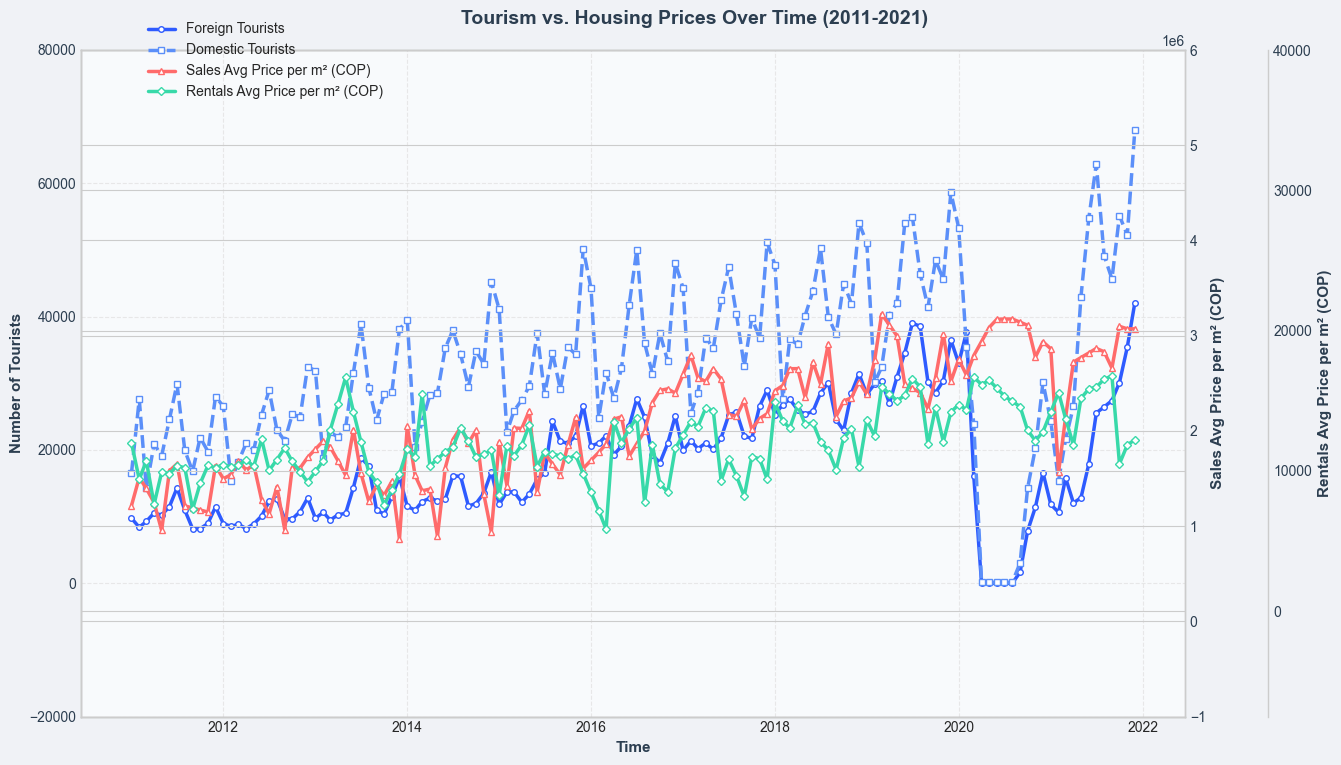

In [18]:
# Define paths for the updated combined plot
plot_name = "/tourism_vs_housing_combined.jpeg"
combined_tourism_housing_path = output_dir + plot_name

# Define custom ranges for the combined plot
tourists_range = (-20000, 80000)          # Range for tourists
sales_price_range = (500000-1500000, 4000000+2000000)     # Range for sales prices
rentals_price_range = (-7500, 40000)  # Range for rental prices

def plot_combined_tourism_and_housing(data, x_col, y1_col, y2_col, y3_col, y4_col,
                                    y1_label, y2_label, y3_label,
                                    tourists_range, sales_price_range, rentals_price_range,
                                    title, output_path):
    """
    Plot three lines with two tourism lines on the same axis and separate housing axes.
    Enhanced with improved styling and colors.
    """
    # Set the style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure and axis with a darker background
    fig, ax1 = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('#F0F2F6')
    ax1.set_facecolor('#F8FAFC')
    
    # Define professional color palette
    foreign_tourist_color = '#2E5BFF'      # Rich blue
    domestic_tourist_color = '#5B8FF9'     # Lighter blue
    sales_color = '#FF6B6B'               # Coral red
    rentals_color = '#38D9A9'             # Mint green
    
    # Create the first y-axis for both tourists
    ax1.set_xlabel("Time", fontsize=11, fontweight='bold', color='#2C3E50')
    ax1.set_ylabel("Number of Tourists", fontsize=11, fontweight='bold', color='#2C3E50')
    
    # Plot tourism data with enhanced line styles
    l1, = ax1.plot(data[x_col], data[y1_col], label=y1_label, 
                   color=foreign_tourist_color, linewidth=2.5,
                   marker='o', markersize=4, markerfacecolor='white')
    l2, = ax1.plot(data[x_col], data[y4_col], label="Domestic Tourists",
                   color=domestic_tourist_color, linewidth=2.5, linestyle='--',
                   marker='s', markersize=4, markerfacecolor='white')
    
    ax1.tick_params(axis="y", labelcolor='#2C3E50')
    ax1.set_ylim(tourists_range)
    
    # Create the second y-axis for Sales Price
    ax2 = ax1.twinx()
    ax2.set_ylabel(y2_label, fontsize=11, fontweight='bold', color='#2C3E50')
    l3, = ax2.plot(data[x_col], data[y2_col], label=y2_label,
                   color=sales_color, linewidth=2.5,
                   marker='^', markersize=4, markerfacecolor='white')
    ax2.tick_params(axis="y", labelcolor='#2C3E50')
    ax2.set_ylim(sales_price_range)
    
    # Create the third y-axis for Rentals Price
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.set_ylabel(y3_label, fontsize=11, fontweight='bold', color='#2C3E50')
    l4, = ax3.plot(data[x_col], data[y3_col], label=y3_label,
                   color=rentals_color, linewidth=2.5,
                   marker='D', markersize=4, markerfacecolor='white')
    ax3.tick_params(axis="y", labelcolor='#2C3E50')
    ax3.set_ylim(rentals_price_range)
    
    # Enhance grid
    ax1.grid(True, linestyle='--', alpha=0.7, color='#E0E0E0')
    
    # Add legend with enhanced styling
    legend = fig.legend([l1, l2, l3, l4], 
                       [y1_label, "Domestic Tourists", y2_label, y3_label],
                       loc='upper left', bbox_to_anchor=(0.1, 0.95),
                       facecolor='white', edgecolor='#E0E0E0',
                       fontsize=10)
    legend.get_frame().set_alpha(0.9)
    
    # Title with enhanced styling
    fig.suptitle(title, fontsize=14, fontweight='bold', color='#2C3E50', y=0.95)
    
    # Layout adjustments
    fig.tight_layout()
    fig.subplots_adjust(right=0.85, top=0.9)
    
    # Save the plot with higher quality
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()

# Create the updated combined plot
plot_combined_tourism_and_housing(
    filtered_data,
    "Period",
    "Total_Foreign_Travelers",
    "Sales_Avg_Price_per_m2",
    "Rentals_Avg_Price_per_m2",
    "Total_Colombian_Travelers",
    "Foreign Tourists",
    "Sales Avg Price per m² (COP)",
    "Rentals Avg Price per m² (COP)",
    tourists_range,
    sales_price_range,
    rentals_price_range,
    "Tourism vs. Housing Prices Over Time (2011-2021)",
    combined_tourism_housing_path
)

In [245]:
# Compute correlation coefficients for the specified periods
# Filter the data for each period
data_2011_2021 = filtered_data[(filtered_data['Period'] >= "2011-01-01") & (filtered_data['Period'] <= "2021-12-31")]
data_2011_2019 = filtered_data[(filtered_data['Period'] >= "2011-01-01") & (filtered_data['Period'] <= "2019-12-31")]
data_2021 = filtered_data[(filtered_data['Period'] >= "2021-01-01") & (filtered_data['Period'] <= "2021-12-31")]

# Define columns to compute correlations
tourist_columns = ['Total_Foreign_Travelers', 'Total_Colombian_Travelers']
housing_columns = ['Sales_Avg_Price_per_m2', 'Rentals_Avg_Price_per_m2']

# Function to compute correlations
def compute_correlations(data, tourists, housing):
    results = {}
    for tourist in tourists:
        for housing_var in housing:
            correlation = data[[tourist, housing_var]].corr().iloc[0, 1]
            results[f"{tourist} vs {housing_var}"] = correlation
    return results

# Compute correlations for each period
print("Correlations period 2011-2021")
correlations_2011_2021 = compute_correlations(data_2011_2021, tourist_columns, housing_columns)
print(correlations_2011_2021)
print("------------------------------------\n")
print("Correlations period 2011-2019")
correlations_2011_2019 = compute_correlations(data_2011_2019, tourist_columns, housing_columns)
print(correlations_2011_2019)
print("------------------------------------\n")
print("Correlations period 2021")
correlations_2021 = compute_correlations(data_2021, tourist_columns, housing_columns)
print(correlations_2021)

# correlations_2011_2021, correlations_2011_2019, correlations_2021


Correlations period 2011-2021
{'Total_Foreign_Travelers vs Sales_Avg_Price_per_m2': np.float64(0.3877366378996858), 'Total_Foreign_Travelers vs Rentals_Avg_Price_per_m2': np.float64(0.16377380797668895), 'Total_Colombian_Travelers vs Sales_Avg_Price_per_m2': np.float64(0.2227012910025733), 'Total_Colombian_Travelers vs Rentals_Avg_Price_per_m2': np.float64(0.05458366667753471)}
------------------------------------

Correlations period 2011-2019
{'Total_Foreign_Travelers vs Sales_Avg_Price_per_m2': np.float64(0.7410204202901519), 'Total_Foreign_Travelers vs Rentals_Avg_Price_per_m2': np.float64(0.4176926143101974), 'Total_Colombian_Travelers vs Sales_Avg_Price_per_m2': np.float64(0.5602159714088726), 'Total_Colombian_Travelers vs Rentals_Avg_Price_per_m2': np.float64(0.2985995577465568)}
------------------------------------

Correlations period 2021
{'Total_Foreign_Travelers vs Sales_Avg_Price_per_m2': np.float64(0.5981356550115113), 'Total_Foreign_Travelers vs Rentals_Avg_Price_per_m2'

#### **<h3 style="text-align:center;">4. Statistical Modeling</h3>**

##### 4.1. Multiple Linear Regression: Check the significance of the coefficients to see if either type of tourism is a significant predictor of housing prices.
##### 4.2. Time‐Series Methods


In [173]:
# !pip install statsmodels

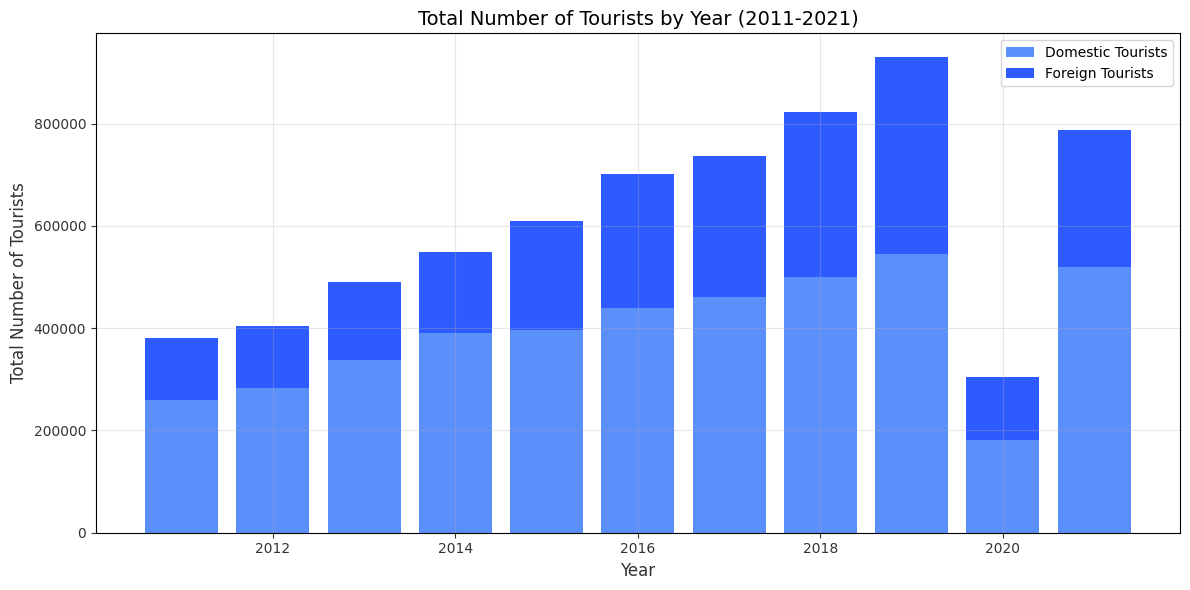

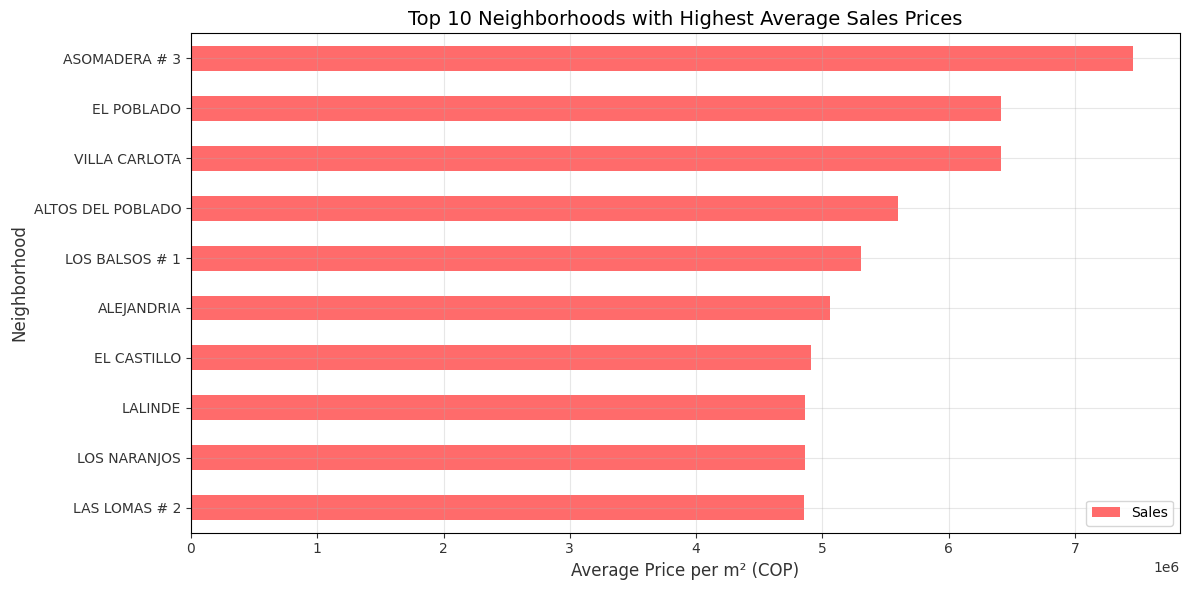

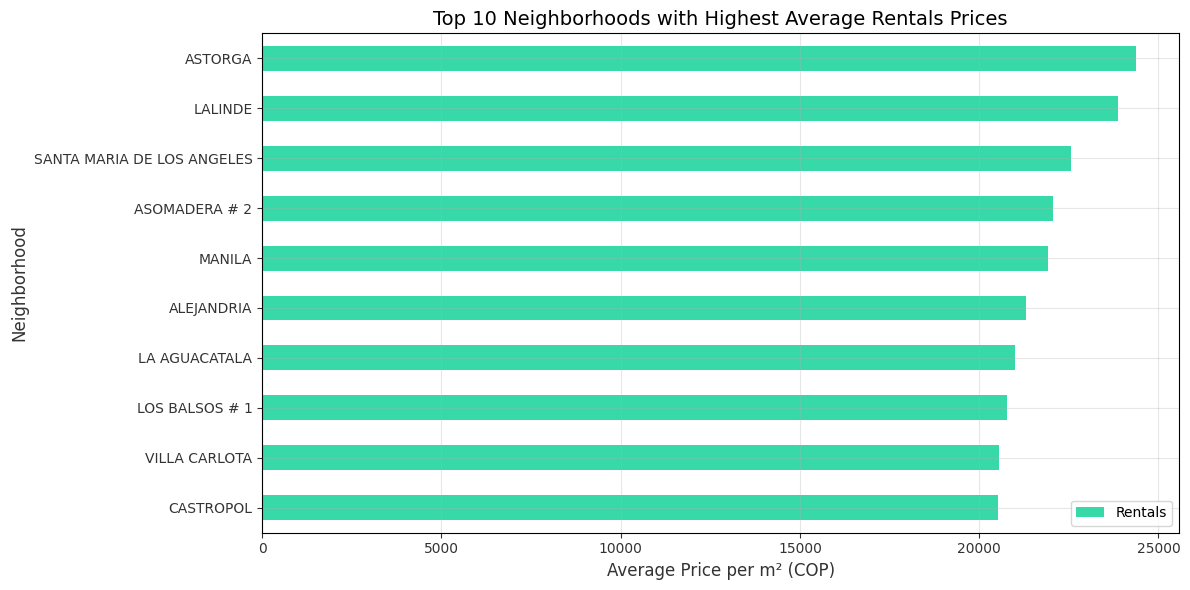

In [23]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Fetch table names to confirm structure
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(table_query, conn)

# Load the three tables into pandas DataFrames
tables_data = {table: pd.read_sql_query(f"SELECT * FROM {table}", conn) for table in tables['name']}

# Close connection
conn.close()

# Function to convert Period column to datetime (for further processing)
def convert_period_to_date(df, period_col):
    df[period_col] = pd.to_datetime(df[period_col] + ".01", format="%Y.%m.%d")
    return df

# Convert Period column in each table to datetime format
tables_data['sales_rents_2011_2021'] = convert_period_to_date(tables_data['sales_rents_2011_2021'], 'Period')
tables_data['monthly_entry_colombians_foreigners'] = convert_period_to_date(tables_data['monthly_entry_colombians_foreigners'], 'Period')

# Aggregate tourism data
domestic_tourism = (
    tables_data['monthly_entry_colombians_foreigners']
    .loc[tables_data['monthly_entry_colombians_foreigners']['Nationality'] == 'Colombiano']
    .groupby(tables_data['monthly_entry_colombians_foreigners']['Period'].dt.year)['Number']
    .sum()
    .reset_index()
    .rename(columns={'Number': 'Total_Colombian_Travelers', 'Period': 'Year'})
)

foreign_tourism = (
    tables_data['monthly_entry_colombians_foreigners']
    .loc[tables_data['monthly_entry_colombians_foreigners']['Nationality'] == 'Extranjero']
    .groupby(tables_data['monthly_entry_colombians_foreigners']['Period'].dt.year)['Number']
    .sum()
    .reset_index()
    .rename(columns={'Number': 'Total_Foreign_Travelers', 'Period': 'Year'})
)

# Merge tourism data
tourism_data = pd.merge(domestic_tourism, foreign_tourism, on='Year', how='outer')
tourism_data = tourism_data[(tourism_data['Year'] >= 2011) & (tourism_data['Year'] <= 2021)]

# Filter and prepare housing data
filtered_data = tables_data['sales_rents_2011_2021']
filtered_data = filtered_data[(filtered_data['Period'] >= '2011-01-01') & (filtered_data['Period'] <= '2021-12-31')]
filtered_data['Year'] = filtered_data['Period'].dt.year

# Plot 1: Vertical Stacked Bar Chart for Tourists
plt.figure(figsize=(12, 6))
plt.bar(tourism_data['Year'], tourism_data['Total_Colombian_Travelers'], label='Domestic Tourists', color='#5B8FF9')
plt.bar(tourism_data['Year'], tourism_data['Total_Foreign_Travelers'], 
        bottom=tourism_data['Total_Colombian_Travelers'], label='Foreign Tourists', color='#2E5BFF')
plt.title('Total Number of Tourists by Year (2011-2021)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Number of Tourists', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


# Plot 2: Top 10 Neighborhoods with Highest Average Prices
avg_prices = (
    filtered_data.groupby(['Neighborhood', 'Research'])['Price_per_m2_COP']
    .mean()
    .reset_index()
    .pivot(index='Neighborhood', columns='Research', values='Price_per_m2_COP')
    .dropna()
)
top_10_sales = avg_prices.nlargest(10, 'VENTA')['VENTA']
top_10_rentals = avg_prices.nlargest(10, 'ARRENDAMIENTO')['ARRENDAMIENTO']

plt.figure(figsize=(12, 6))
top_10_sales.sort_values(ascending=True).plot(kind='barh', color='#FF6B6B', label='Sales')
plt.title('Top 10 Neighborhoods with Highest Average Sales Prices', fontsize=14)
plt.xlabel('Average Price per m² (COP)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
top_10_rentals.sort_values(ascending=True).plot(kind='barh', color='#38D9A9', label='Rentals')
plt.title('Top 10 Neighborhoods with Highest Average Rentals Prices', fontsize=14)
plt.xlabel('Average Price per m² (COP)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


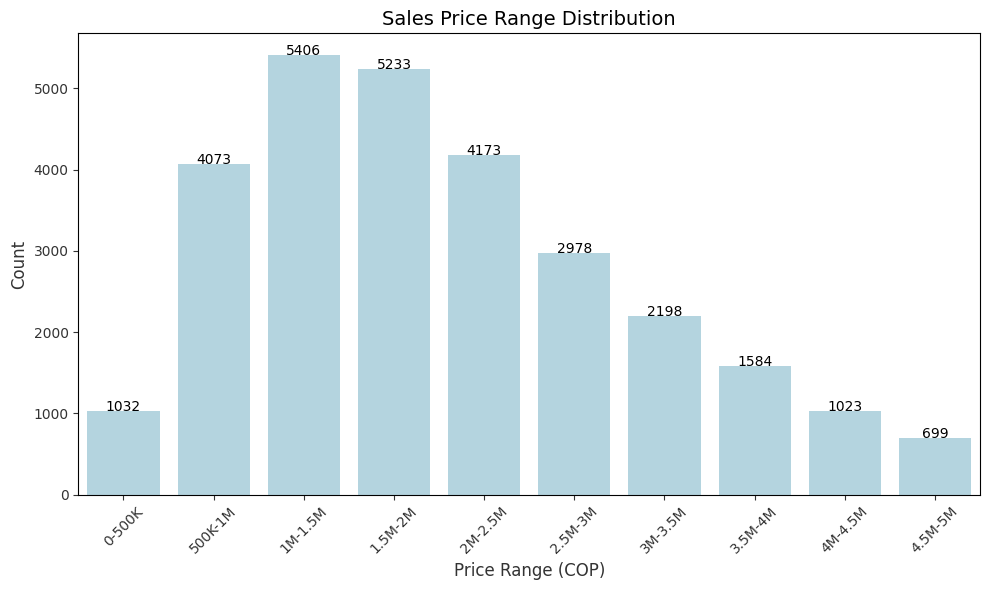

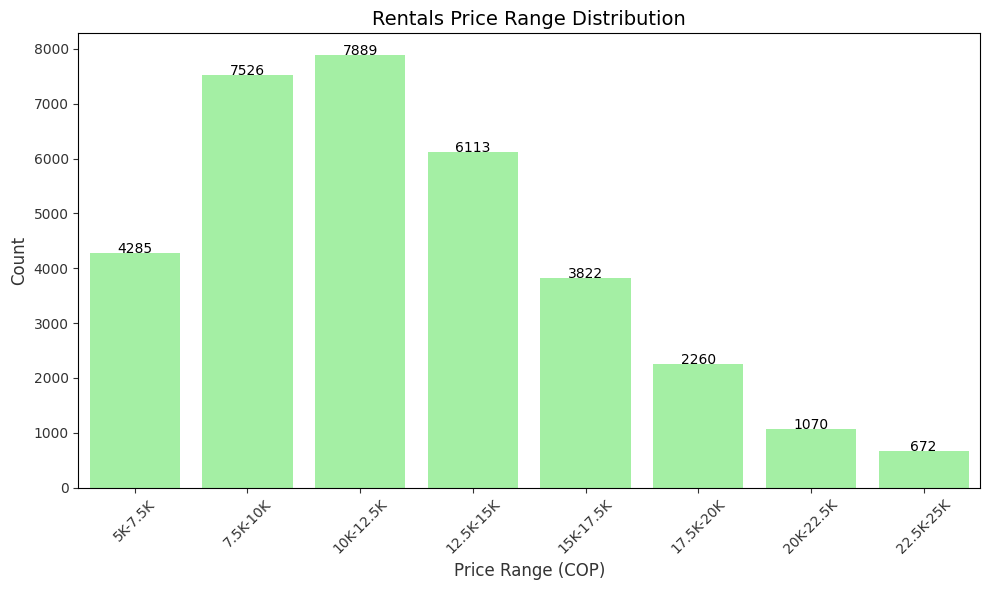

In [24]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Fetch table names to confirm structure
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(table_query, conn)

# Load the three tables into pandas DataFrames
tables_data = {table: pd.read_sql_query(f"SELECT * FROM {table}", conn) for table in tables['name']}

# Close connection
conn.close()

# Function to convert Period column to datetime (for further processing)
def convert_period_to_date(df, period_col):
    df[period_col] = pd.to_datetime(df[period_col] + ".01", format="%Y.%m.%d")
    return df

# Convert Period column in each table to datetime format
tables_data['sales_rents_2011_2021'] = convert_period_to_date(tables_data['sales_rents_2011_2021'], 'Period')

# Extract sales and rental data from the original dataset
sales_data = tables_data['sales_rents_2011_2021'][tables_data['sales_rents_2011_2021']['Research'] == 'VENTA']
rentals_data = tables_data['sales_rents_2011_2021'][tables_data['sales_rents_2011_2021']['Research'] == 'ARRENDAMIENTO']

# Sales Price Range Distribution
sales_data['Sales_Price_Range'] = pd.cut(
    sales_data['Price_per_m2_COP'],
    bins=[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000],
    labels=['0-500K', '500K-1M', '1M-1.5M', '1.5M-2M', '2M-2.5M', '2.5M-3M', '3M-3.5M', '3.5M-4M', '4M-4.5M', '4.5M-5M']
)
sales_price_range_counts = sales_data['Sales_Price_Range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=sales_price_range_counts.index.astype(str),
    y=sales_price_range_counts.values,
    color='#ADD8E6'  # Light blue color
)
for i, value in enumerate(sales_price_range_counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=10)
plt.title('Sales Price Range Distribution', fontsize=14)
plt.xlabel('Price Range (COP)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Rentals Price Range Distribution
rentals_data['Rentals_Price_Range'] = pd.cut(
    rentals_data['Price_per_m2_COP'],
    bins=[5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000],
    labels=['5K-7.5K', '7.5K-10K', '10K-12.5K', '12.5K-15K', '15K-17.5K', '17.5K-20K', '20K-22.5K', '22.5K-25K']
)
rentals_price_range_counts = rentals_data['Rentals_Price_Range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=rentals_price_range_counts.index.astype(str),
    y=rentals_price_range_counts.values,
    color='#98FB98'  # Light green color
)
for i, value in enumerate(rentals_price_range_counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=10)
plt.title('Rentals Price Range Distribution', fontsize=14)
plt.xlabel('Price Range (COP)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


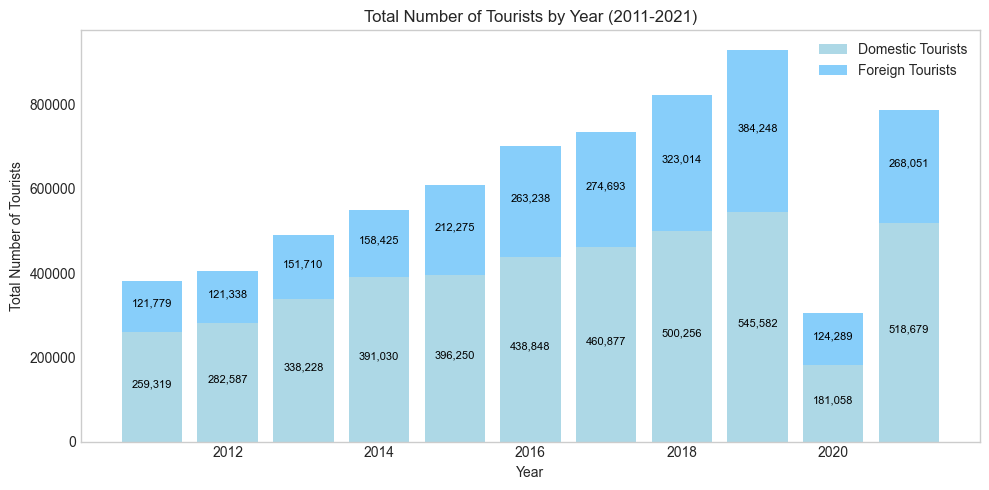

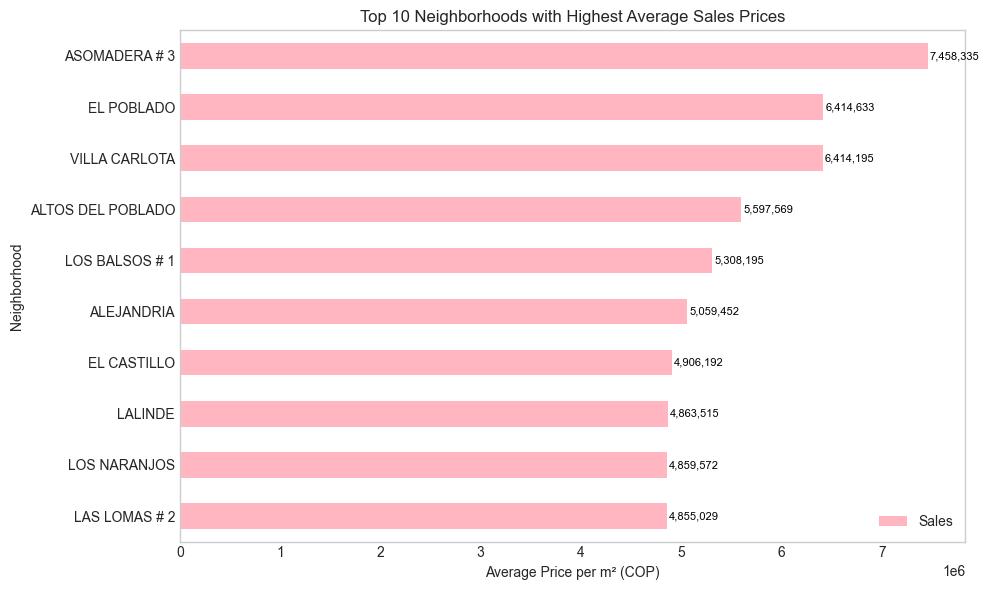

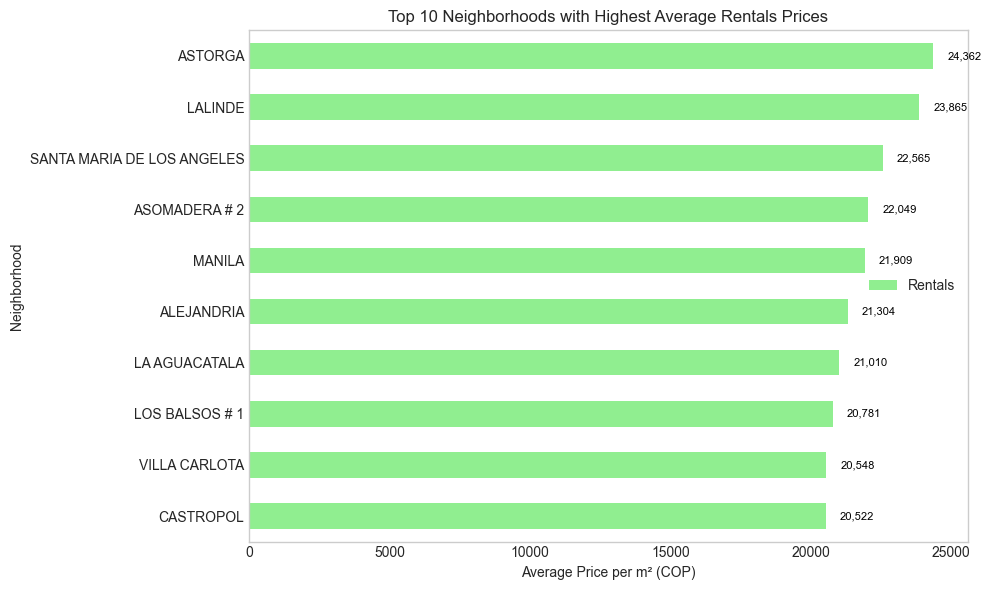

In [10]:
# Adjusted Figure Size and Text Scaling

# Plot 1: Vertical Stacked Bar Chart for Tourists
plt.figure(figsize=(10, 5))  # Reduced figure size
plt.bar(tourism_data['Year'], tourism_data['Total_Colombian_Travelers'], label='Domestic Tourists', color='#ADD8E6')
plt.bar(tourism_data['Year'], tourism_data['Total_Foreign_Travelers'], 
        bottom=tourism_data['Total_Colombian_Travelers'], label='Foreign Tourists', color='#87CEFA')
for i, (domestic, foreign) in enumerate(zip(tourism_data['Total_Colombian_Travelers'], tourism_data['Total_Foreign_Travelers'])):
    plt.text(tourism_data['Year'].iloc[i], domestic / 2, f"{domestic:,}", ha='center', fontsize=8, color='black')
    plt.text(tourism_data['Year'].iloc[i], domestic + foreign / 2, f"{foreign:,}", ha='center', fontsize=8, color='black')
plt.title('Total Number of Tourists by Year (2011-2021)', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Total Number of Tourists', fontsize=10)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 2: Top 10 Neighborhoods with Highest Average Prices
plt.figure(figsize=(10, 6))
top_10_sales.sort_values(ascending=True).plot(kind='barh', color='#FFB6C1', label='Sales')
for i, value in enumerate(top_10_sales.sort_values(ascending=True)):
    plt.text(value + 20000, i, f"{value:,.0f}", va='center', fontsize=8, color='black')
plt.title('Top 10 Neighborhoods with Highest Average Sales Prices', fontsize=12)
plt.xlabel('Average Price per m² (COP)', fontsize=10)
plt.ylabel('Neighborhood', fontsize=10)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
top_10_rentals.sort_values(ascending=True).plot(kind='barh', color='#90EE90', label='Rentals')
for i, value in enumerate(top_10_rentals.sort_values(ascending=True)):
    plt.text(value + 500, i, f"{value:,.0f}", va='center', fontsize=8, color='black')
plt.title('Top 10 Neighborhoods with Highest Average Rentals Prices', fontsize=12)
plt.xlabel('Average Price per m² (COP)', fontsize=10)
plt.ylabel('Neighborhood', fontsize=10)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


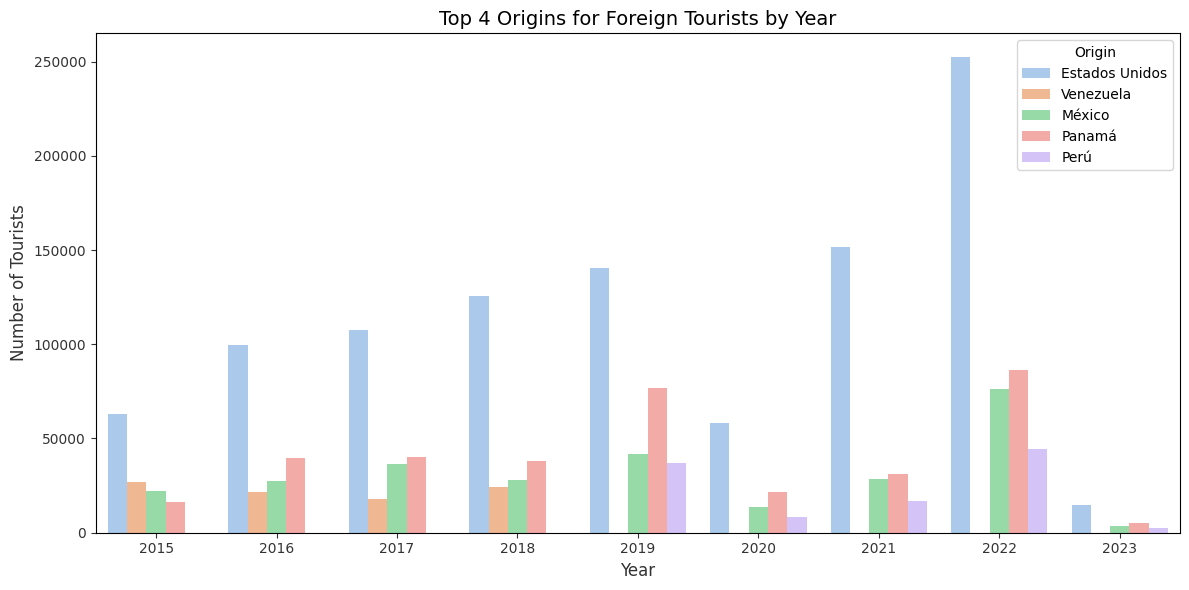

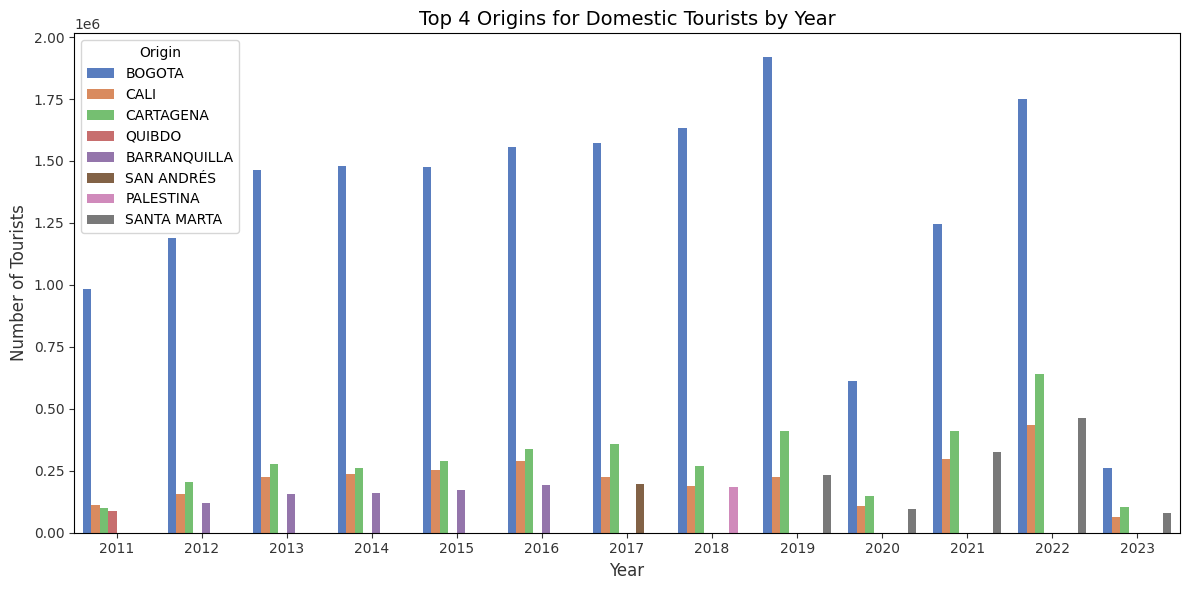

In [25]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Load the 'monthly_passengers_origin' table
passengers_data = pd.read_sql_query("SELECT * FROM monthly_passengers_origin", conn)

# Close connection
conn.close()

# Convert Period column to datetime and extract the year
passengers_data['Period'] = pd.to_datetime(passengers_data['Period'], format="%Y.%m")
passengers_data['Year'] = passengers_data['Period'].dt.year

# Function to get top 4 origins by year
def get_top_origins(df, nationality, top_n=4):
    filtered_df = df[df['Nationality'] == nationality]
    top_origins = (
        filtered_df.groupby(['Year', 'Origin'])['Number']
        .sum()
        .reset_index()
        .sort_values(['Year', 'Number'], ascending=[True, False])
        .groupby('Year')
        .head(top_n)
    )
    return top_origins

# Get top 4 origins for foreign and domestic passengers
foreign_origins = get_top_origins(passengers_data, 'Extranjero')
domestic_origins = get_top_origins(passengers_data, 'Colombiano')

# Plot 1: Top 4 Foreign Origins
plt.figure(figsize=(12, 6))
sns.barplot(
    data=foreign_origins,
    x='Year',
    y='Number',
    hue='Origin',
    palette='pastel'
)
plt.title('Top 4 Origins for Foreign Tourists by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Tourists', fontsize=12)
plt.legend(title='Origin')
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 2: Top 4 Domestic Origins
plt.figure(figsize=(12, 6))
sns.barplot(
    data=domestic_origins,
    x='Year',
    y='Number',
    hue='Origin',
    palette='muted'
)
plt.title('Top 4 Origins for Domestic Tourists by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Tourists', fontsize=12)
plt.legend(title='Origin', loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()


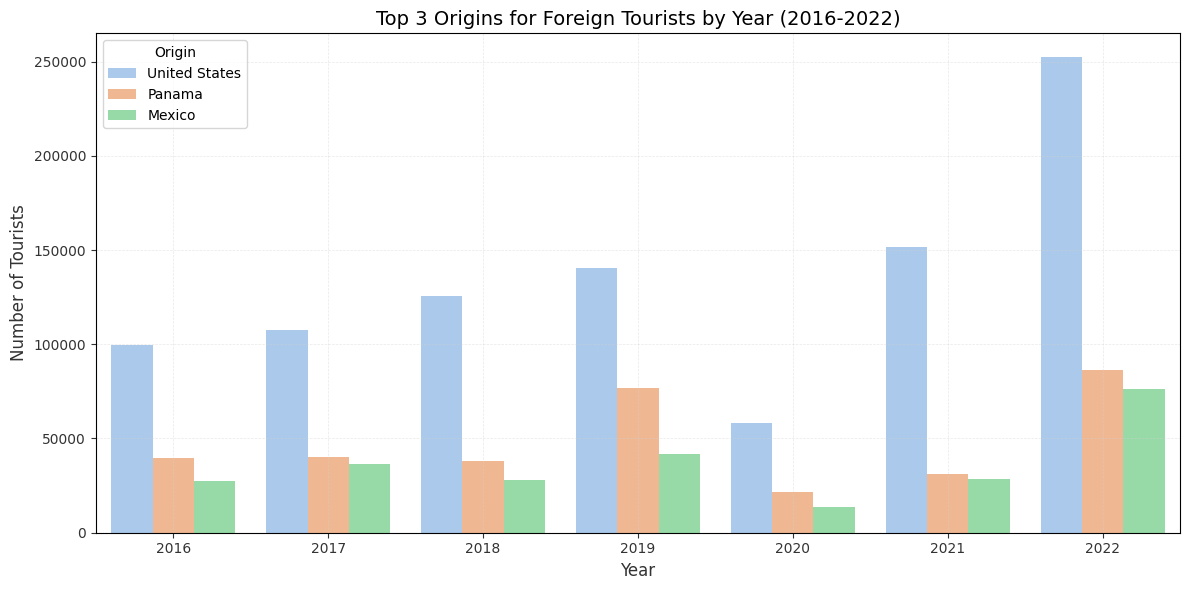

In [26]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Load the 'monthly_passengers_origin' table
passengers_data = pd.read_sql_query("SELECT * FROM monthly_passengers_origin", conn)

# Close connection
conn.close()

# Convert Period column to datetime and extract the year
passengers_data['Period'] = pd.to_datetime(passengers_data['Period'], format="%Y.%m")
passengers_data['Year'] = passengers_data['Period'].dt.year

# Limit data to the time period 2011-2021
passengers_data = passengers_data[(passengers_data['Year'] >= 2016) & (passengers_data['Year'] <= 2022)]

# Function to get top 3 origins by year
def get_top_origins(df, nationality, top_n=3):
    filtered_df = df[df['Nationality'] == nationality]
    top_origins = (
        filtered_df.groupby(['Year', 'Origin'])['Number']
        .sum()
        .reset_index()
        .sort_values(['Year', 'Number'], ascending=[True, False])
        .groupby('Year')
        .head(top_n)
    )
    return top_origins

# Translate origin names from Spanish to English
def translate_origin(origin):
    translations = {
        'Estados Unidos': 'United States',
        'España': 'Spain',
        'México': 'Mexico',
        'Argentina': 'Argentina',
        'Brasil': 'Brazil',
        'Canadá': 'Canada',
        'Alemania': 'Germany',
        'Panamá': 'Panama'
    }
    return translations.get(origin, origin)

# Get top 3 origins for foreign passengers
foreign_origins = get_top_origins(passengers_data, 'Extranjero', top_n=3)

# Translate Origin column to English
foreign_origins['Origin'] = foreign_origins['Origin'].apply(translate_origin)

# Plot: Top 3 Foreign Origins by Year
plt.figure(figsize=(12, 6))
sns.barplot(
    data=foreign_origins,
    x='Year',
    y='Number',
    hue='Origin',
    palette='pastel'
)
plt.title('Top 3 Origins for Foreign Tourists by Year (2016-2022)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Tourists', fontsize=12)
plt.legend(title='Origin')
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)  # Subtle grid
plt.tight_layout()
plt.show()


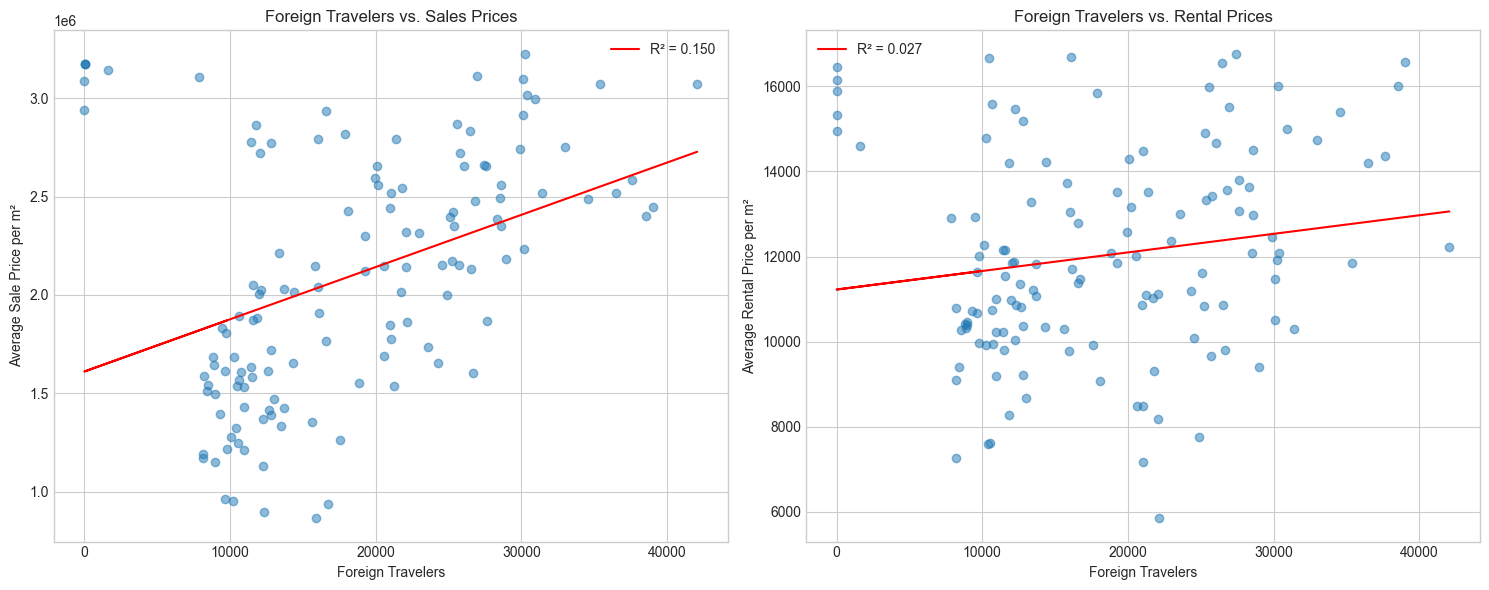

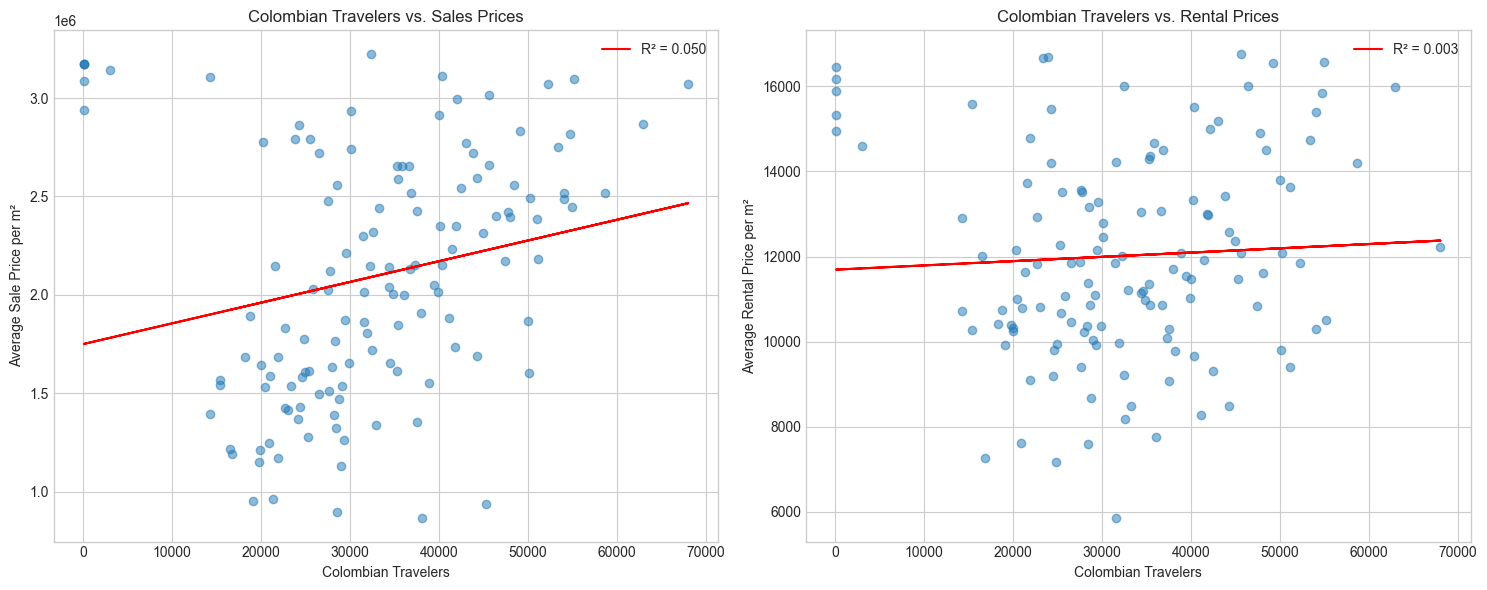

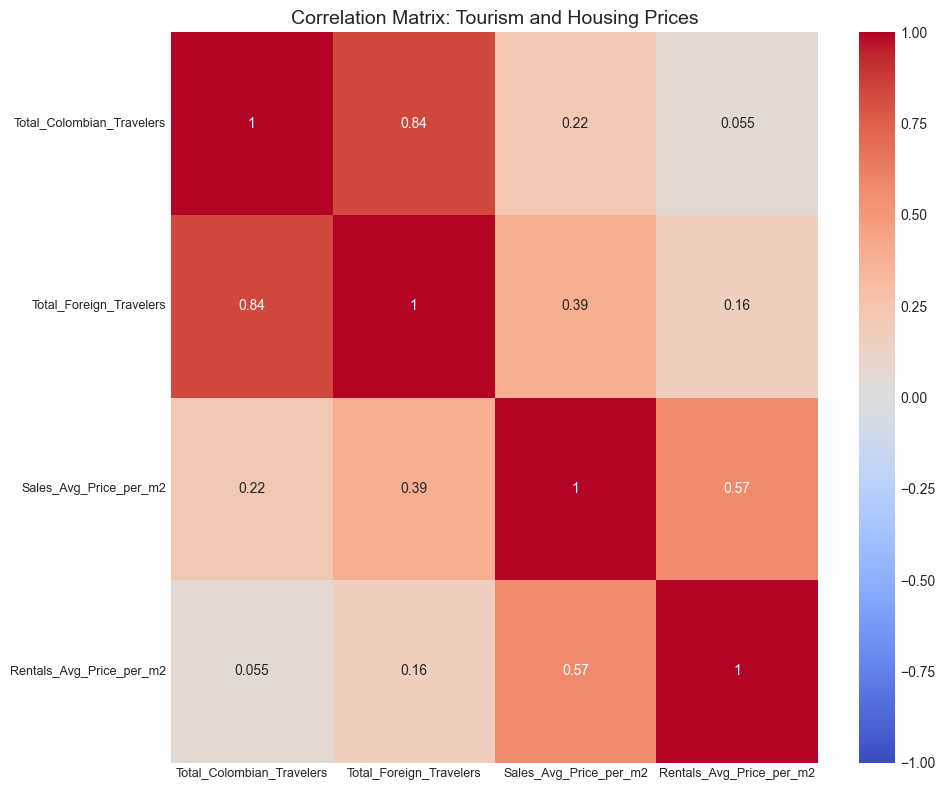

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create figure for foreign travelers scatter plots
plt.figure(figsize=(15, 6))

# Foreign travelers vs Sales Price
plt.subplot(1, 2, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_data['Total_Foreign_Travelers'],
    filtered_data['Sales_Avg_Price_per_m2']
)
plt.scatter(filtered_data['Total_Foreign_Travelers'], 
            filtered_data['Sales_Avg_Price_per_m2'], 
            alpha=0.5)
plt.plot(filtered_data['Total_Foreign_Travelers'], 
         slope * filtered_data['Total_Foreign_Travelers'] + intercept, 
         color='red', 
         label=f'R² = {r_value**2:.3f}')
plt.xlabel('Foreign Travelers')
plt.ylabel('Average Sale Price per m²')
plt.title('Foreign Travelers vs. Sales Prices')
plt.legend()

# Foreign travelers vs Rental Price
plt.subplot(1, 2, 2)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_data['Total_Foreign_Travelers'],
    filtered_data['Rentals_Avg_Price_per_m2']
)
plt.scatter(filtered_data['Total_Foreign_Travelers'], 
            filtered_data['Rentals_Avg_Price_per_m2'], 
            alpha=0.5)
plt.plot(filtered_data['Total_Foreign_Travelers'], 
         slope * filtered_data['Total_Foreign_Travelers'] + intercept, 
         color='red', 
         label=f'R² = {r_value**2:.3f}')
plt.xlabel('Foreign Travelers')
plt.ylabel('Average Rental Price per m²')
plt.title('Foreign Travelers vs. Rental Prices')
plt.legend()
plt.tight_layout()
plt.show()

# Create figure for Colombian travelers scatter plots
plt.figure(figsize=(15, 6))

# Colombian travelers vs Sales Price
plt.subplot(1, 2, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_data['Total_Colombian_Travelers'],
    filtered_data['Sales_Avg_Price_per_m2']
)
plt.scatter(filtered_data['Total_Colombian_Travelers'], 
            filtered_data['Sales_Avg_Price_per_m2'], 
            alpha=0.5)
plt.plot(filtered_data['Total_Colombian_Travelers'], 
         slope * filtered_data['Total_Colombian_Travelers'] + intercept, 
         color='red', 
         label=f'R² = {r_value**2:.3f}')
plt.xlabel('Colombian Travelers')
plt.ylabel('Average Sale Price per m²')
plt.title('Colombian Travelers vs. Sales Prices')
plt.legend()

# Colombian travelers vs Rental Price
plt.subplot(1, 2, 2)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_data['Total_Colombian_Travelers'],
    filtered_data['Rentals_Avg_Price_per_m2']
)
plt.scatter(filtered_data['Total_Colombian_Travelers'], 
            filtered_data['Rentals_Avg_Price_per_m2'], 
            alpha=0.5)
plt.plot(filtered_data['Total_Colombian_Travelers'], 
         slope * filtered_data['Total_Colombian_Travelers'] + intercept, 
         color='red', 
         label=f'R² = {r_value**2:.3f}')
plt.xlabel('Colombian Travelers')
plt.ylabel('Average Rental Price per m²')
plt.title('Colombian Travelers vs. Rental Prices')
plt.legend()
plt.tight_layout()
plt.show()

# Correlation matrix
variables_of_interest = [
    'Total_Colombian_Travelers',
    'Total_Foreign_Travelers',
    'Sales_Avg_Price_per_m2',
    'Rentals_Avg_Price_per_m2'
]

correlation_matrix = filtered_data[variables_of_interest].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0,
            annot_kws={"size": 10})  # Adjust font size of annotations
plt.title('Correlation Matrix: Tourism and Housing Prices', fontsize=14)  # Adjust title font size
plt.xticks(rotation=0, fontsize=9.0)  # Set x-axis labels horizontal and reduce font size
plt.yticks(rotation=0, fontsize=9.0)  # Reduce y-axis labels font size
plt.tight_layout()
plt.show()




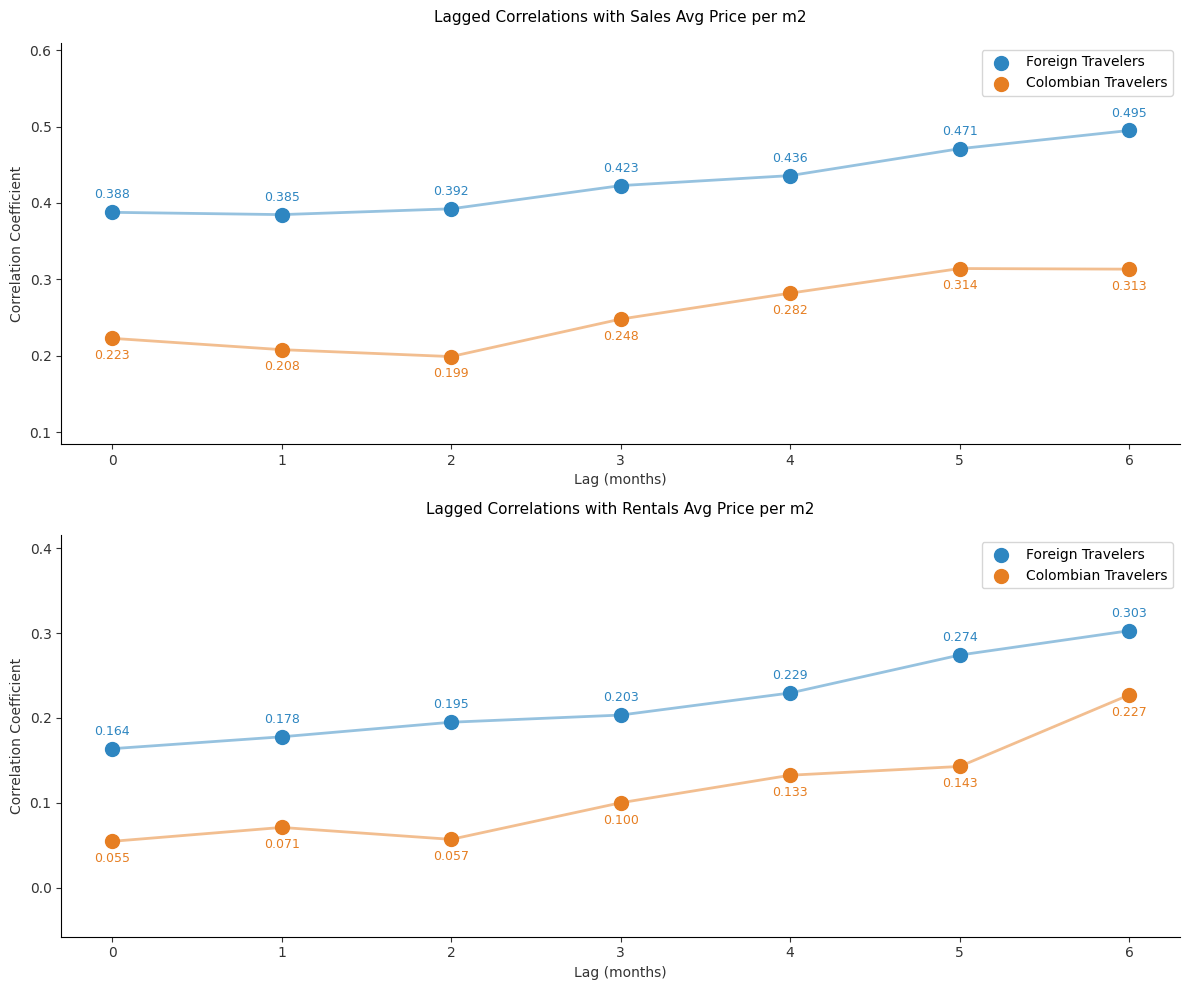

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Create lagged versions of tourism data (up to 6 months)
max_lags = 6
tourism_cols = ['Total_Foreign_Travelers', 'Total_Colombian_Travelers']
price_cols = ['Sales_Avg_Price_per_m2', 'Rentals_Avg_Price_per_m2']

# Create lagged columns
for col in tourism_cols:
    for lag in range(1, max_lags + 1):
        filtered_data[f'{col}_lag{lag}'] = filtered_data[col].shift(lag)

# Calculate correlations for each lag
lag_correlations = {price: [] for price in price_cols}

for price in price_cols:
    for lag in range(max_lags + 1):
        corr_data = {}
        for tourism in tourism_cols:
            if lag == 0:
                corr = filtered_data[tourism].corr(filtered_data[price])
            else:
                corr = filtered_data[f'{tourism}_lag{lag}'].corr(filtered_data[price])
            corr_data[tourism] = corr
        lag_correlations[price].append(corr_data)

# Plot lag correlations with values
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.patch.set_facecolor('white')

for idx, (price, corrs) in enumerate(lag_correlations.items()):
    lags = list(range(max_lags + 1))
    foreign_corrs = [c['Total_Foreign_Travelers'] for c in corrs]
    colombian_corrs = [c['Total_Colombian_Travelers'] for c in corrs]
    
    ax = axes[idx]
    
    # Plot lines and points
    ax.plot(lags, foreign_corrs, '-', color='#2E86C1', alpha=0.5, 
            linewidth=2, zorder=1)
    ax.plot(lags, colombian_corrs, '-', color='#E67E22', alpha=0.5,
            linewidth=2, zorder=1)
    
    # Plot points
    foreign_scatter = ax.scatter(lags, foreign_corrs, color='#2E86C1', s=100,
                               label='Foreign Travelers', zorder=2)
    colombian_scatter = ax.scatter(lags, colombian_corrs, color='#E67E22', s=100,
                                 label='Colombian Travelers', zorder=2)
    
    # Add correlation values above points
    for x, y in zip(lags, foreign_corrs):
        ax.annotate(f'{y:.3f}', (x, y), xytext=(0, 10), 
                   textcoords='offset points', ha='center', 
                   color='#2E86C1', fontsize=9)
    
    for x, y in zip(lags, colombian_corrs):
        ax.annotate(f'{y:.3f}', (x, y), xytext=(0, -15), 
                   textcoords='offset points', ha='center', 
                   color='#E67E22', fontsize=9)
    
    ax.set_xlabel('Lag (months)', fontsize=10)
    ax.set_ylabel('Correlation Coefficient', fontsize=10)
    ax.set_title(f'Lagged Correlations with {price.replace("_", " ")}',
                 pad=15, fontsize=11)
    
    # Remove grid and spines
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Set y-axis limits to accommodate annotations
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 0.1, ymax + 0.1)
    
    # Set x-axis ticks
    ax.set_xticks(lags)

plt.tight_layout()
plt.show()

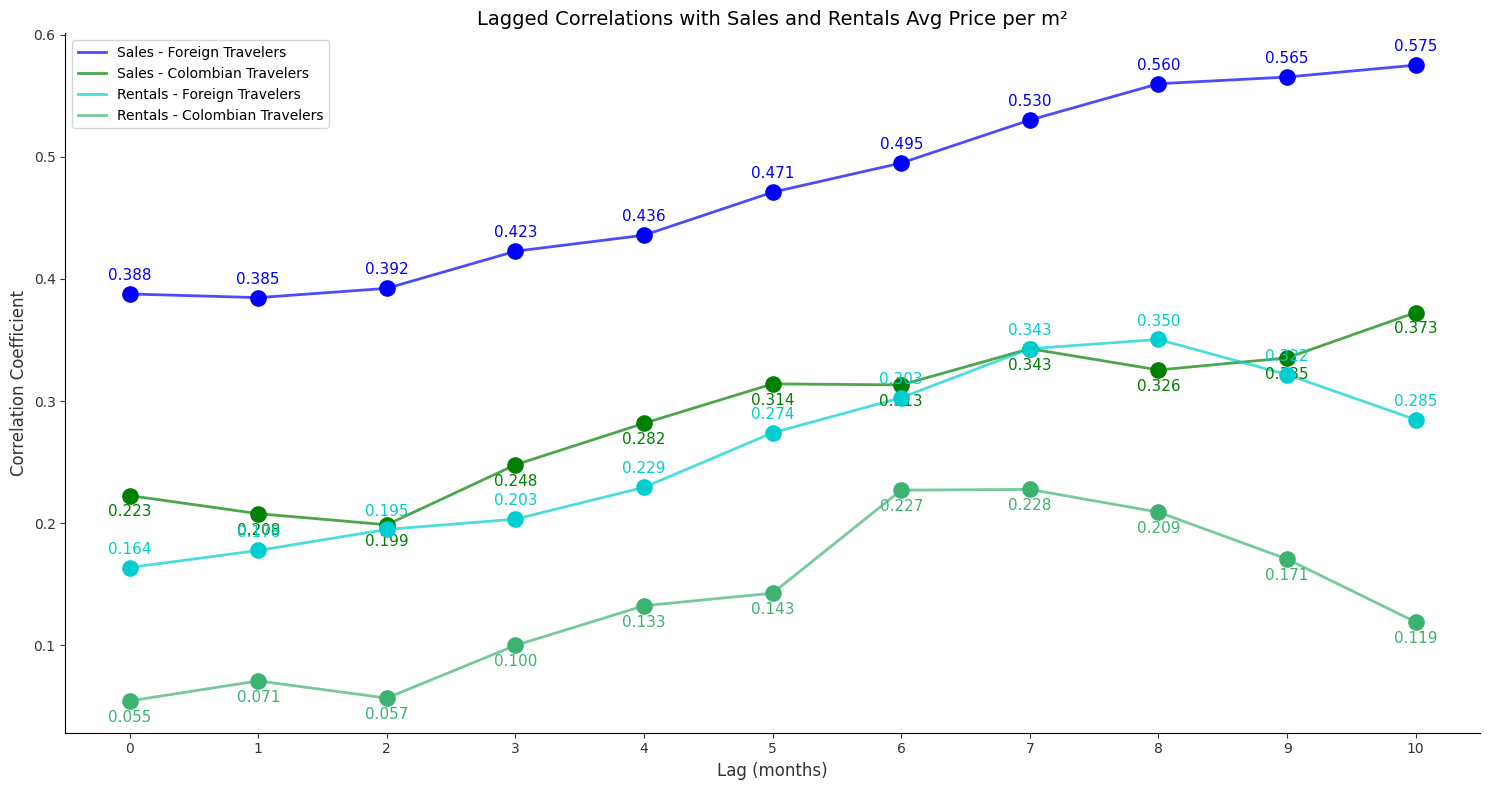


Maximum Correlations and Their Lags:
--------------------------------------------------

For Sales_Avg_Price_per_m2:
Total_Foreign_Travelers:
  Maximum correlation: 0.575
  At lag: 10 months
Total_Colombian_Travelers:
  Maximum correlation: 0.373
  At lag: 10 months

For Rentals_Avg_Price_per_m2:
Total_Foreign_Travelers:
  Maximum correlation: 0.350
  At lag: 8 months
Total_Colombian_Travelers:
  Maximum correlation: 0.228
  At lag: 7 months


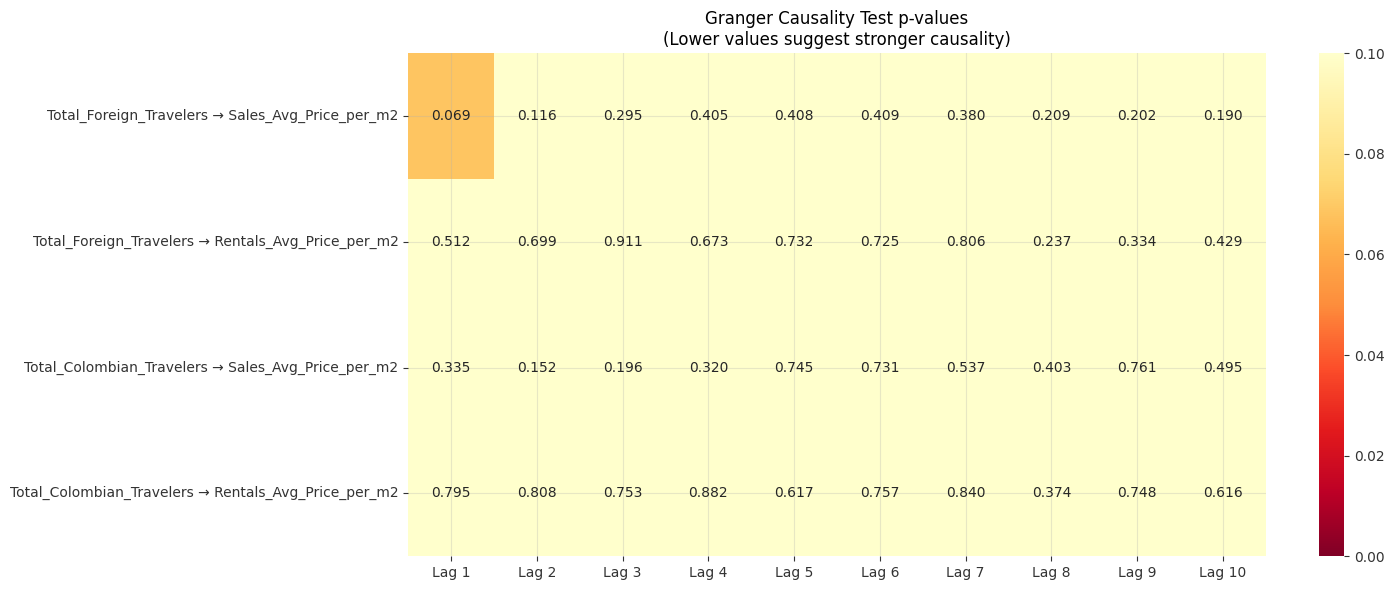

In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Extend to 10 months of lags
max_lags = 10
tourism_cols = ['Total_Foreign_Travelers', 'Total_Colombian_Travelers']
price_cols = ['Sales_Avg_Price_per_m2', 'Rentals_Avg_Price_per_m2']

# Create lagged columns
for col in tourism_cols:
    for lag in range(1, max_lags + 1):
        filtered_data[f'{col}_lag{lag}'] = filtered_data[col].shift(lag)

# Calculate correlations for each lag
lag_correlations = {price: [] for price in price_cols}

for price in price_cols:
    for lag in range(max_lags + 1):
        corr_data = {}
        for tourism in tourism_cols:
            if lag == 0:
                corr = filtered_data[tourism].corr(filtered_data[price])
            else:
                corr = filtered_data[f'{tourism}_lag{lag}'].corr(filtered_data[price])
            corr_data[tourism] = corr
        lag_correlations[price].append(corr_data)

# Combine Lagged Correlations into a Single Plot
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor('white')

# Define labels and colors
labels = [
    ('Sales - Foreign Travelers', '#0000FF'),
    ('Sales - Colombian Travelers', '#008000'),
    ('Rentals - Foreign Travelers', '#00ced1'),
    ('Rentals - Colombian Travelers', '#3cb371')
]

# Extract correlations for plotting
correlations = [
    [c['Total_Foreign_Travelers'] for c in lag_correlations['Sales_Avg_Price_per_m2']],
    [c['Total_Colombian_Travelers'] for c in lag_correlations['Sales_Avg_Price_per_m2']],
    [c['Total_Foreign_Travelers'] for c in lag_correlations['Rentals_Avg_Price_per_m2']],
    [c['Total_Colombian_Travelers'] for c in lag_correlations['Rentals_Avg_Price_per_m2']]
]

# Lags for x-axis
lags = list(range(max_lags + 1))

# Plot each line
for idx, (label, color) in enumerate(labels):
    ax.plot(lags, correlations[idx], '-', color=color, alpha=0.7, linewidth=2, label=label)
    ax.scatter(lags, correlations[idx], color=color, s=120, zorder=3)  # Larger dots
    for x, y in zip(lags, correlations[idx]):
        ax.annotate(f'{y:.3f}', (x, y), xytext=(0, 10 if idx % 2 == 0 else -15), 
                    textcoords='offset points', ha='center', color=color, fontsize=11)

# Customize plot appearance
ax.set_xlabel('Lag (months)', fontsize=12)
ax.set_ylabel('Correlation Coefficient', fontsize=12)
ax.set_title('Lagged Correlations with Sales and Rentals Avg Price per m²', fontsize=14)
ax.legend(loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(lags)
ax.set_xticklabels(lags)
ax.grid(False)  # Remove grid
plt.tight_layout()
plt.show()

# Print maximum correlations and their corresponding lags
print("\nMaximum Correlations and Their Lags:")
print("-" * 50)
for price in price_cols:
    print(f"\nFor {price}:")
    for tourism in tourism_cols:
        corrs = [c[tourism] for c in lag_correlations[price]]
        max_corr = max(corrs)
        max_lag = corrs.index(max_corr)
        print(f"{tourism}:")
        print(f"  Maximum correlation: {max_corr:.3f}")
        print(f"  At lag: {max_lag} months")

# Extend Granger causality tests to 10 lags
granger_results = {}
for tourism in tourism_cols:
    for price in price_cols:
        key = f"{tourism} → {price}"
        df = pd.DataFrame({
            'x': filtered_data[tourism],
            'y': filtered_data[price]
        }).dropna()
        granger_results[key] = grangercausalitytests(df[['x', 'y']], maxlag=max_lags, verbose=False)

# Extract and visualize Granger causality p-values
def get_granger_p_values(results):
    return [results[lag][0]['ssr_chi2test'][1] for lag in range(1, max_lags + 1)]

granger_p_values = {k: get_granger_p_values(v) for k, v in granger_results.items()}
granger_df = pd.DataFrame(granger_p_values, index=[f'Lag {i}' for i in range(1, max_lags + 1)]).T

# Plot updated Granger causality heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(granger_df, 
            annot=True, 
            fmt='.3f', 
            cmap='YlOrRd_r',
            center=0.05,
            vmin=0,
            vmax=0.1)
plt.title('Granger Causality Test p-values\n(Lower values suggest stronger causality)')
plt.tight_layout()
plt.show()
